In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [47]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
import wispy.waveutils
import wispy.model_utils

In [4]:
category_indices = [0, 1, 2, 2, 1, 0]
unique_category_count = 3
inputs = tf.one_hot(category_indices, unique_category_count)
print(inputs.numpy())

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [5]:
# tf.one_hot does not accept string catagories
# so need to integer encode them first
categories = ['IMRPhenomC', 'IMRPhenomD', 'NR', 'SEOBNRv4_opt', 'NR']

# 0: IMRPhenomC
# 1: IMRPhenomD
# 2: NR
# 3: SEOBNRv4_opt

int_encoding = [0, 1, 2, 3, 2]
inputs = tf.one_hot(int_encoding, 4)
print(inputs.numpy())

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [6]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [7]:
# training_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/eob_phend_nr/training_data")
training_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/add_phenC/training_data")

In [8]:
# validation_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/eob_phend_nr/validation_data")
validation_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/add_phenC/validation_data")

In [9]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [10]:
training_data['mask']

{'IMRPhenomC': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
        252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
        265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
        278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
        291, 292, 293, 294, 295, 296, 297, 298, 299]),
 'IMRPhenomD': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89

In [261]:
def get_training_data(data, data_name, onehot=True, freq=False):
    x_tmp = {}
    y_tmp = {}
    for i, approx in enumerate(data['unique_approximants']):
        print(f"working {approx}")
        mask = data['mask'][approx]
        num_cases = len(mask)
        qs = data['mass_ratios'][mask]
        names = np.repeat(i, num_cases)
        x_tmp[approx] = np.transpose((names, qs))
        y_tmp[approx] = data[data_name][mask]
        
    x = np.row_stack([x_tmp[approx] for approx in x_tmp.keys()])
    y = np.row_stack([y_tmp[approx] for approx in y_tmp.keys()])
    
    if freq:
        for i in range(len(y)):
            y[i] = IUS(data['times'], y[i]).derivative()(data['times'])
        ymax = np.max(y)
        print(f"ymax = {ymax}")
        y = y/ymax
    
    if onehot:
        onehot_encode = tf.one_hot(x[:,0], len(data['unique_approximants']))
        x = np.column_stack((onehot_encode, x[:,1]))
    
    return x, y

In [262]:
def build_decoder(input_shape, output_shape, units, acts, skip=False):
    # build the decoder
    input_layer = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(input_layer)
        else:
            x = layers.Dense(unit, activation=act)(x)
            
    if skip:
        x = layers.Dense(input_shape, activation='linear')(x)
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
            
    timeseries_output = layers.Dense(output_shape, activation="linear")(x)
    decoder_model = keras.Model(input_layer, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model

In [263]:
def setup_modelling(data_name, training_data, validation_data, skip=False, onehot=True, freq=False):
    print(f"data_name: {data_name}")
    x, y = get_training_data(training_data, data_name, onehot, freq)
    xval, yval = get_training_data(validation_data, data_name, onehot, freq)
    
    NR_NUM = int(np.where(training_data["unique_approximants"]=="NR")[0][0])
    
#     nr_latent = [0.,0.,0.,0.]
#     nr_latent[NR_NUM] = 1.
#     print(NR_NUM)

    sample_weight = np.ones(len(y),)

#     sample_weight[training_data['mask']["NR"]] = 10
#     print(nr_latent)
    
    sample_weight[x[:,NR_NUM]==1] = 10
    
    output_shape = y.shape[1]
    input_shape = x.shape[1]
    

    units = [16, 128, 512]
    acts = ['relu', 'relu', 'relu']

    # units = [16, 128]
    # acts = ['relu', 'relu']

    # units = [16, 128, 128, 128]
    # acts = ['relu', 'relu', 'relu', 'relu']

    print(f"input_shape = {input_shape}")
    print(f"output_shape = {output_shape}")
    
    model = build_decoder(input_shape, output_shape, units, acts, skip=skip)
    
    print(sample_weight)
    return model, dict(x=x, y=y, xval=xval, yval=yval, sample_weight=sample_weight)

In [264]:
times = training_data['times']

In [333]:
model_phase, phase_training_data = setup_modelling("phase", training_data, validation_data, skip=False)

data_name: phase
working IMRPhenomC
working IMRPhenomD
working NR
working SEOBNRv4_opt
working IMRPhenomC
working IMRPhenomD
working SEOBNRv4_opt
input_shape = 5
output_shape = 4150
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. 10. 10

In [266]:
model_freq, freq_training_data = setup_modelling("phase", training_data, validation_data, skip=False, freq=True)

data_name: phase
working IMRPhenomC
working IMRPhenomD
working NR
working SEOBNRv4_opt
ymax = 0.0032752775485651586
working IMRPhenomC
working IMRPhenomD
working SEOBNRv4_opt
ymax = 0.0032752775485651586
input_shape = 5
output_shape = 4150
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  

In [267]:
freq_training_data['x']

array([[ 1. ,  0. ,  0. ,  0. ,  1. ],
       [ 1. ,  0. ,  0. ,  0. ,  1.1],
       [ 1. ,  0. ,  0. ,  0. ,  1.2],
       ...,
       [ 0. ,  0. ,  0. ,  1. , 10.7],
       [ 0. ,  0. ,  0. ,  1. , 10.8],
       [ 0. ,  0. ,  0. ,  1. , 10.9]])

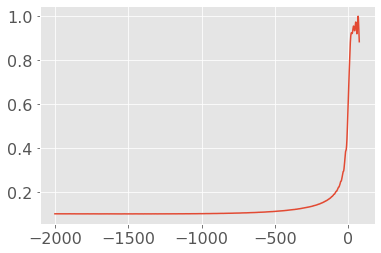

In [268]:
plt.figure()
plt.plot(times, freq_training_data['y'][0])

In [269]:
phase_training_data['x'].shape 

(305, 5)

In [270]:
phase_training_data['y'].shape 

(305, 4150)

In [271]:
phase_training_data['xval'].shape 

(540, 4)

In [272]:
phase_training_data['yval'].shape 

(540, 4150)

In [273]:
def initial_fit(model, x, y, validation_data=None, epochs=10000, batch_size=100, validation_freq=100, lr=None, sample_weight=None):
        
    loss = 'mae'
    metrics = ['mse']

    if lr == None:
        boundaries = [5000, 5100]
        values = [1e-3, 1e-4, 1e-5]
#         boundaries = [500, 600]
#         values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        opt = tf.keras.optimizers.Adam(learning_rate_fn)
    else:
        opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    history = model.fit(
        x=x,
        y=y,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        validation_freq=validation_freq,
        sample_weight=sample_weight
    )

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    if validation_data is not None:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['val_mse'], label='val_mse')

        plt.yscale('log')
        plt.legend()
    
    return history, model

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 58min 30s, sys: 8min 15s, total: 1h 6min 45s
Wall time: 14min 22s


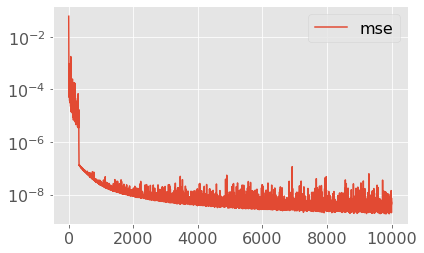

In [334]:
%%time
phase_history, model_phase = initial_fit(
    model_phase,
    x=phase_training_data['x'],
    y=phase_training_data['y'],
#     validation_data=(phase_training_data['xval'], phase_training_data['yval']),
    validation_data=None,
    epochs=10000,
    batch_size=20,
    validation_freq=1000,
    lr=None,
    sample_weight=phase_training_data['sample_weight']
)

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 58min 9s, sys: 8min 58s, total: 1h 7min 7s
Wall time: 16min 3s


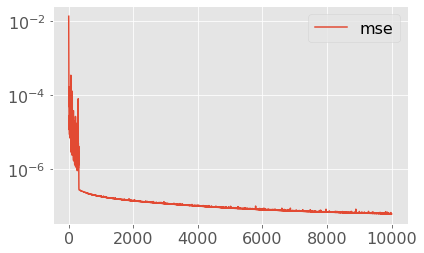

In [274]:
%%time
freq_history, model_freq = initial_fit(
    model_freq,
    x=freq_training_data['x'],
    y=freq_training_data['y'],
#     validation_data=(freq_training_data['xval'], freq_training_data['yval']),
    validation_data=None,
    epochs=10000,
    batch_size=20,
    validation_freq=1000,
    lr=None,
    sample_weight=freq_training_data['sample_weight']
)

In [275]:
def compare_models(model, x, y, index, times=times):
    
    yhat = model.predict(x)[index]
    
    y = y[index]
    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='true')
    plt.plot(times, yhat, label='yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(-200, 20)
#     plt.ylim(0.4, 0.9)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, y-yhat, label='y-yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.ylim(-0.01,0.01)
    
    title = f"(approx,q)={np.around(x[index], 3)}"
    plt.suptitle(title)

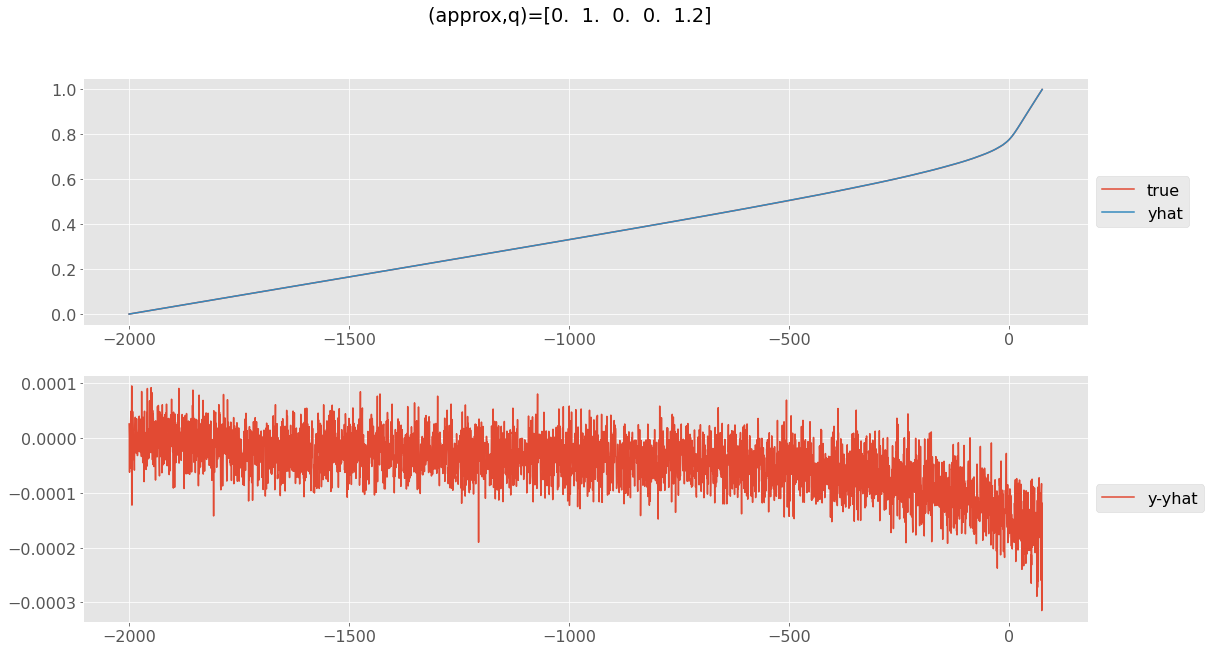

In [335]:
compare_models(model_phase, phase_training_data['x'], phase_training_data['y'], 102)

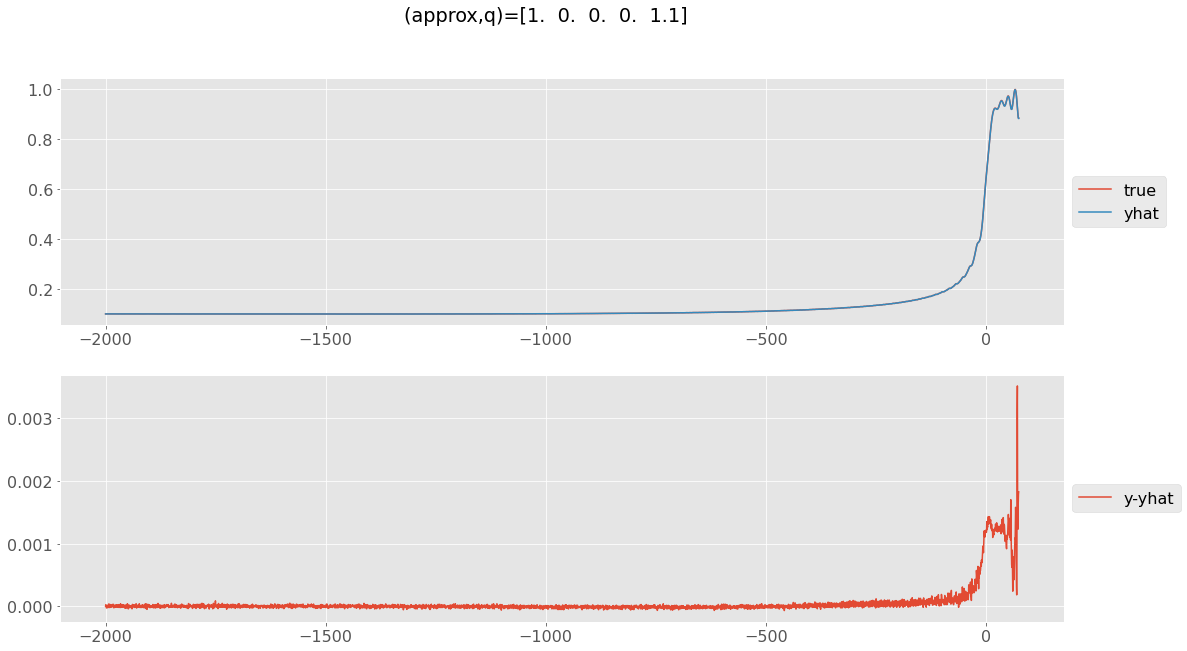

In [304]:
compare_models(model_freq, freq_training_data['x'], freq_training_data['y'], 1)

In [350]:
def latent_space_interpolation(model):

    q = 1
    n = 10
    
    xxs = []
    for i in range(n):
        a0 = 1-i/(n-1)
        a1 = i/(n-1)
        
#         xx = [a0, a1, 0., 0., q]
#         xx = [a0, 0., a1, 0., q]
#         xx = [a0, 0, 0, a1, q]
#         xx = [0, a0, a1, 0., q]
#         xx = [0, a0, 0., a1, q]
    
    
        xx = [0, 0, a0, a1, q]


        xx = list(map(lambda x: np.around(x, 3), xx))

        xxs.append(xx)
    
    plt.figure(figsize=(18, 4))

    for i in range(n):

        xx = xxs[i]
        yhat = model.predict(np.array([xx]))[0]
        plt.subplot(1, n, i+1)
        plt.plot(times, yhat, label='yhat')
#         plt.xlim(-100, 100)
#         plt.xlim(-100, 70)
#         plt.yscale('log')
        plt.title(xx, fontsize=10)

    
    ##
    
    plt.figure(figsize=(18, 8))
    
    yhats = []
    for i in range(n):

        xx = xxs[i]
        
        yhats.append(model.predict(np.array([xx]))[0])

    for i in range(n):
        if i == 0:
            plt.plot(times, yhats[i], label=xxs[i], lw=3)
        elif i == n-1:
            plt.plot(times, yhats[i], label=xxs[i], lw=3, ls='--')
        else:
            plt.plot(times, yhats[i], label=xxs[i])
        plt.xlim(-100, 100)
#         plt.xlim(-300, 100)
#         plt.xlim(-100, 20)
        plt.ylim(0.5, 1.)
#         plt.yscale('log')
#         plt.title(xx, fontsize=10)
        plt.legend()
    
    plt.figure(figsize=(18, 8))
    for i in range(n):
        if i != 0:
            plt.plot(times, yhats[0]-yhats[i], label=i)
#         plt.xlim(-100, 100)
#         plt.xlim(-300, 100)
#         plt.xlim(-100, 20)
#         plt.ylim(0.5, 0.8)
#         plt.yscale('log')
#         plt.title(xx, fontsize=10)
        plt.legend()
    
    
#     dyhats = []
    
#     plt.figure(figsize=(18, 8))
    
#     for yhat in yhats:

#         dyhat = IUS(times, yhat).derivative()(times)
#         dyhats.append(dyhat)
        
#     for i in range(n):
        
#         if i in [0, n-1]:
#             plt.plot(times, dyhats[i], label=xxs[i])
# #         plt.xlim(-100, 100)
# #         plt.xlim(-100, 20)
# #         plt.ylim(0.5, 1.1)
# #         plt.yscale('log')
# #         plt.title(xx, fontsize=10)
#         plt.legend()

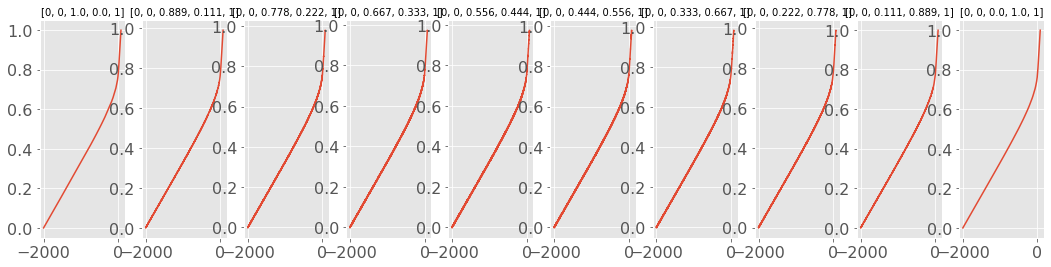

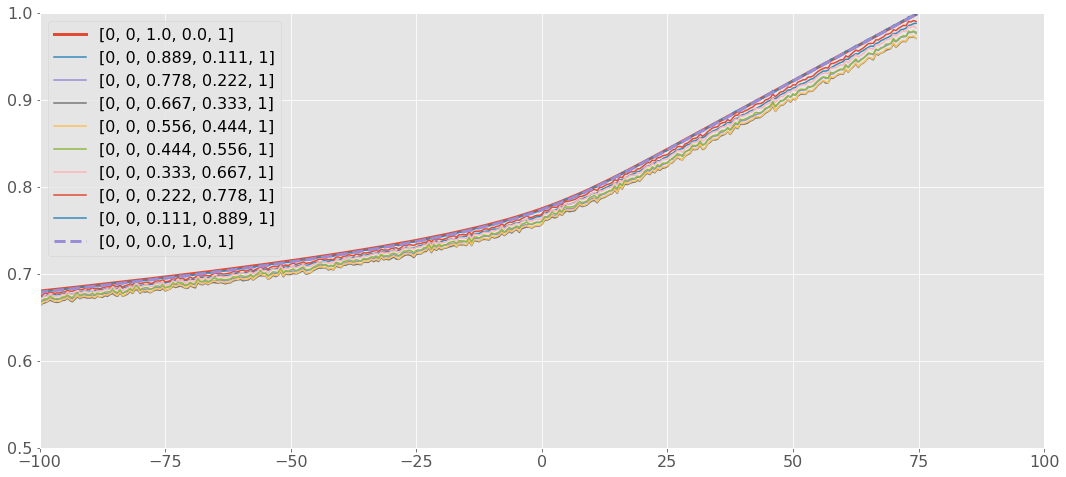

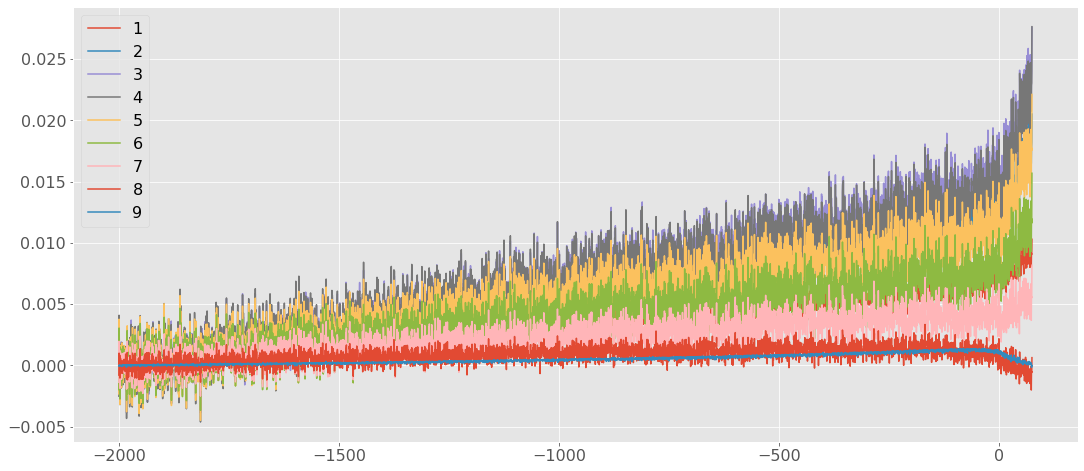

In [351]:
latent_space_interpolation(model=model_phase)

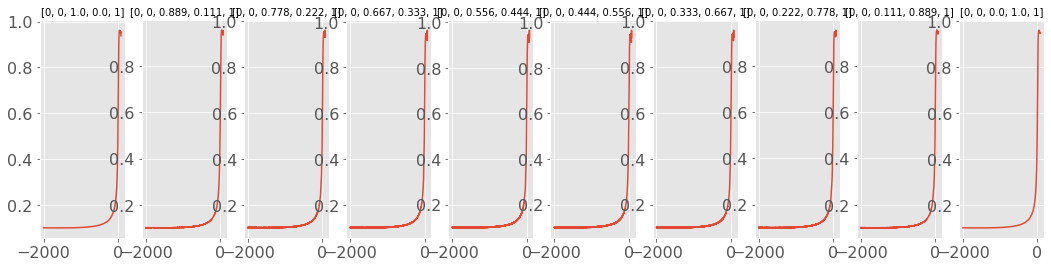

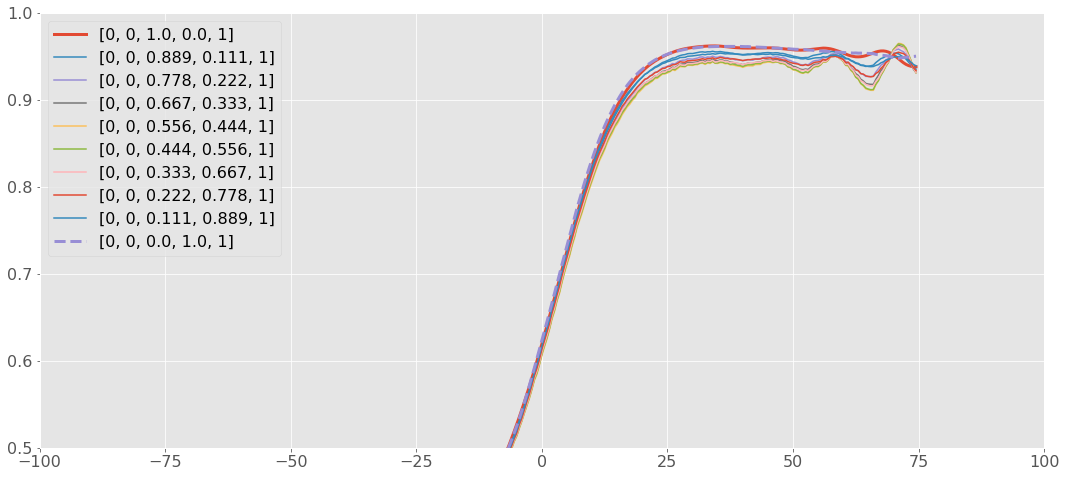

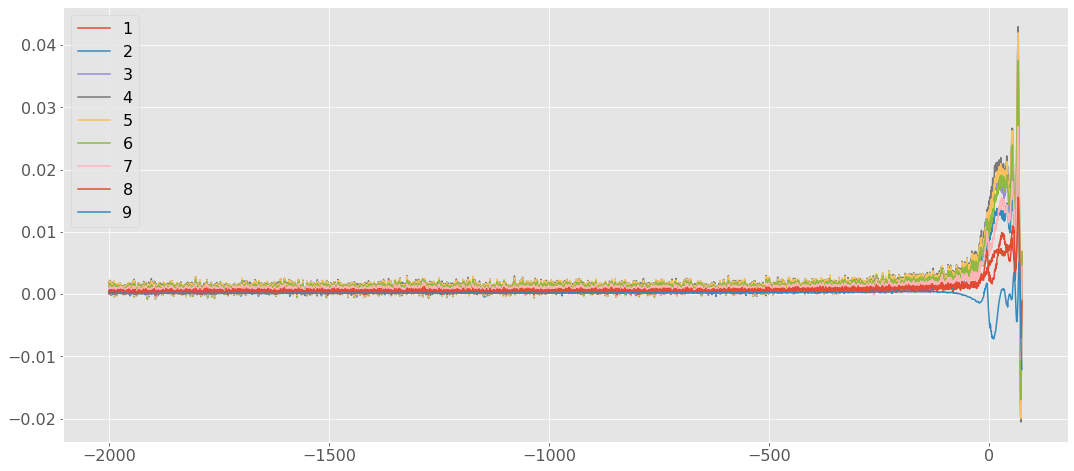

In [352]:
latent_space_interpolation(model=model_freq)

In [ ]:
# the interpolation between classes isn't what I was expecting. For the amplitude I think it is but for phase and frequency it is not.
# interpolations between classes are producing data that is too far from the truth.

# integer encoding was producing better results i would say but in that case we basically enforced that different models were closer or further apart than others.

# maybe a adding in a discriminator network ?